In [1]:
from astropy.table import Table, join, Column
import matplotlib.pyplot as plt
import numpy as np
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting
from my_progs.catalog.pos_diff import pos_diff_calc

Read these two catalogs.

In [2]:
# read source position from VLBI and Gaia catalogs.
from my_progs.vlbi.read_sou import read_cat
tv = read_cat("/Users/Neo/Astronomy/Data/VLBISolutions/"
                "vlbi2_server/GalacticAberration/GaiaDR2-timespan-solutions/"
                "gaiadr2-timespan-noGAb.cat")

# Read Gaia DR2 IERS quasar
# tg = Table.read("/Users/Neo/Astronomy/Data/catalogs/Gaia_DR2/"
#                 "gaiadr2_iers.fits")
from my_progs.catalog.read_gaia import read_gaiadr2_qso

tg = read_gaiadr2_qso()

Then I obtained a sample of common sources by the cross-match.

In [3]:
# Cross-match
t_com = join(tv, tg, keys="iers_name", table_names=["v", "g"])

# gaiadr2-vlbi positional offsets (VLBI - Gaia DR2).
[dra, ddec, dra_err, ddec_err, dra_ddec_cor,
 ang_sep, X_a, X_d, X, X2] = pos_diff_calc(
    t_com["ra_v"], t_com["ra_err"], t_com["dec_v"], t_com["dec_err"], t_com["ra_dec_corr_v"],
    t_com["ra_g"],  t_com["ra_error"], t_com["dec_g"], t_com["dec_error"], t_com["ra_dec_corr_g"])

dra_ddec_cov = dra_ddec_cor * dra_err * ddec_err

t_com.add_columns([dra, ddec, dra_err, ddec_err, dra_ddec_cor,
                   ang_sep, X_a, X_d, X, X2],
                  names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
                         "ang_sep", "nor_dra",  "nor_ddec", "nor_sep_cov", "nor_sep"])

There are 1274 common sources. 
Before we investigate the systematcis, we should remove some outliers.

In [4]:
# First we remove sources with less than three observations.
mask1 = (t_com["num_del"] >=3)
t_com1 = t_com[mask1]

In [5]:
# Consider X follow a Rayleigh distribution
N = len(t_com1)
X0 = np.sqrt(2 * np.log(N))

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

# Then we remove these sources with X >= 3.8 or eema >= 10 mas
mask2 = ((t_com1["nor_sep_cov"] <= 3.8) & (t_com1["ang_sep"] <= 10) & (
    t_com1["pos_err_v"] <= 10) & (t_com1["pos_err_g"] <= 10))
t_com2 = t_com1[mask2]

There are 1263 sources.
When X >= 3.78, the number of the outlier is smaller than 1.


This left 1024 common source. Actually, if we adopted the X0 to be 3.78 rather than 3.8, there would be 1023 sources left.

In [6]:
import astropy.units as u

# Genearte some arrays for estimating the ststematics
dra = np.array(t_com2["dra"])
ddec = np.array(t_com2["ddec"])
dra_err = np.array(t_com2["dra_err"])
ddec_err = np.array(t_com2["ddec_err"])
dra_ddec_cov = np.array(t_com2["dra_ddec_cov"])
ra_rad = np.array(t_com2["ra_v"].to(u.radian))
dec_rad = np.array(t_com2["dec_v"].to(u.radian))

In [7]:
# l_max = 1
w1, sig1, corrcoef1, _, _, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err, 
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2, sig2, corrcoef2, _, _, _ = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,  
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1 * 1.e3
sig1 = sig1 * 1.e3
w2 = w2 * 1.e3
sig2 = sig2 * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

# apriori statistics (weighted)
#         mean for RA:      0.021 mas
#         wrms for RA:      0.719 mas
#          std for RA:      0.719 mas
#        mean for Dec:      0.053 mas
#        wrms for Dec:      0.948 mas
#         std for Dec:      0.946 mas

# apriori reduced Chi-square for:      1.797
# posteriori statistics  of vsh01 fit (weighted)
#         mean for RA:      0.014 mas
#          rms for RA:      0.718 mas
#          std for RA:      0.717 mas
#        mean for Dec:      0.064 mas
#         rms for Dec:      0.948 mas
#         std for Dec:      0.946 mas

# posteriori reduced Chi-square for:      1.783
# goodness-of-fit is      0.000
# apriori statistics (weighted)
#         mean for RA:      0.021 mas
#         wrms for RA:      0.719 mas
#          std for RA:      0.719 mas
#        mean for Dec:      0.053 mas
#        wrms for Dec:      0.948 mas
#         std for Dec:      0.946 mas

# apriori reduced Chi-square for:      1.797
# posteriori statistics of vsh

First I removed the global systematics and investigate the radio-to-optical vector.

In [8]:
dRA = np.array(t_com["dra"])
dDC = np.array(t_com["ddec"])
RA = np.array(t_com["ra_v"].to(u.radian))
DE = np.array(t_com["dec_v"].to(u.radian))

# Remove the global systematics
from my_progs.catalog.vsh_deg2_cor import residual_calc02
dRA_ns, dDC_ns = residual_calc02(dRA, dDC, RA, DE, w2/1e3)

t_com["dra"] = dRA_ns
t_com["ddec"] = dDC_ns

Then I re-calculated the positional offset.

In [9]:
from my_progs.catalog.pos_diff import nor_sep, pa_calc

ang_sep_ns, Xa_ns, Xd_ns, X_ns, X2_ns = nor_sep(
    t_com["dra"], t_com["dra_err"], t_com["ddec"], t_com["ddec_err"], 
    t_com["dra_ddec_cov"] / t_com["dra_err"]/t_com["ddec_err"])

pa = pa_calc(dRA_ns, dDC_ns) * u.degree

# Renew these columns
t_com["ang_sep"] = ang_sep_ns
t_com["nor_dra"] = Xa_ns
t_com["nor_ddec"] = Xd_ns
t_com["nor_sep_cov"] = X_ns
t_com["nor_sep"] = X2_ns
t_com["pa"] = pa

First I looked at the distribution of the angular separations.

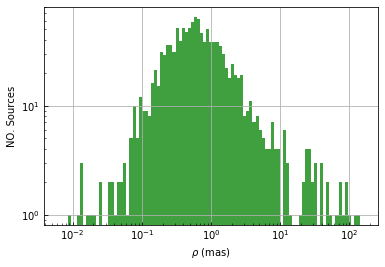

In [10]:
# Distribution of angular separation
bins_array = 10 ** np.linspace(-2.2, 2.2, 100)
# bins_array = np.linspace(0, 100, 500)

fig, ax = plt.subplots()
ax.hist(ang_sep_ns, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("NO. Sources")

ax.set_xscale("log")
ax.set_yscale("log")

ax.grid()

plt.show()

Then I plotted the distribution of the position angle.

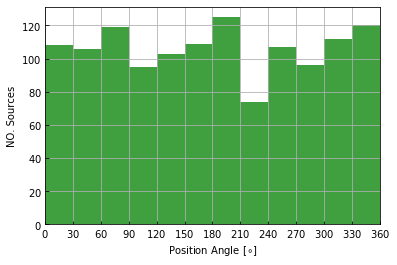

In [16]:
# Distribution of angular separation
bins_array = np.arange(0, 361, 30)

fig, ax = plt.subplots()
ax.hist(pa, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("Position Angle [$\\circ$]")
ax.set_ylabel("NO. Sources")

ax.set_xlim([0, 360])
ax.set_xticks(np.arange(0, 361, 30))

ax.grid()

plt.show()

In [13]:
t_com[t_com["iers_name"] == "1901+319"]

ivs_name,iers_name,ra_v,dec_v,ra_err,dec_err,ra_dec_corr_v,pos_err_v,mean_epo,beg_epo,end_epo,num_sess,num_del,num_delrate,flag,source_id,ra_g,ra_error,dec_g,dec_error,pos_err_g,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr_g,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep_cov,nor_sep,pa
,,deg,deg,mas,mas,,mas,MJD,MJD,MJD,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,,,mas,mas,mas,,,,,,deg
str8,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3C395,1901+319,285.7330790155,31.9949170516,0.3356,0.4337,-0.792,0.5212060177851401,2015.52,2014.67,2016.36,25,340,0,GLO,2043550082305460480,285.7330786935693,0.06904680433030966,31.99491702666236,0.08330907420866653,0.08680309989117191,0.017637246380663777,0.0909468869696384,0.060674311174843454,0.14757848808091648,0.0043225467670227145,0.17550345091956257,0.22295864,0.2155784,-0.2109507,-0.09885033,0.20171407,-0.115573674,-0.16750138,-0.17251743,-0.08135733,0.19739453,17.42942,17.538975,17.081491,1.0146618988330025,0.09707373993218693,0.3426292766069883,0.44162890739341903,-0.11399286990415435,1.0192948935062003,2.9613987131545296,0.21980839185807674,4.760076001402409,2.969545094354443,84.53508711489822
